In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import time

from sklearn.decomposition import PCA, KernelPCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans, DBSCAN, Birch

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import make_scorer
from sklearn import metrics

In [2]:
# Import data
extended_train_features = pd.read_csv('extended_train_features.csv')
extended_train_labels = pd.read_csv('extended_train_labels.csv')

In [3]:
# Remove building id
exclude = ['building_id']
extended_train_features = extended_train_features.drop(columns = exclude)

In [4]:
# Extract most important features
most_important = extended_train_features[['geo_level_1_id', 'geo_level_1_id', 'geo_level_3_id', 'age', 'area_percentage']]

In [5]:
#Standardize extended features 
scaler = StandardScaler()
extended_train_features = scaler.fit_transform(extended_train_features)
features = extended_train_features

In [6]:
#Standardize most important 
scaler1 = StandardScaler()
most_important = scaler1.fit_transform(most_important)

In [7]:
labels = extended_train_labels['damage_grade']
set(labels)

{1, 2, 3}

In [8]:
print(features.shape)
print(most_important.shape)
print(labels.shape)

(258477, 68)
(258477, 5)
(258477,)


### Decrease number of samples

In [11]:
# For most important features

labels_to_short = np.array(labels)

# Class 1
class1 = labels_to_short[np.where(labels_to_short == 1)]
index1 = np.random.choice(len(class1), size = 15000)
class1 = class1[index1]
features_class1 =  most_important[index1]
labels_class1 = labels_to_short[index1]

# Class 2
class2 = labels_to_short[np.where(labels_to_short == 2)]
index2 = np.random.choice(len(class2), size = 15000)
class2 = class2[index2]
features_class2 = most_important[index2]
labels_class2 = labels_to_short[index2]

# Class 3
class3 = labels_to_short[np.where(labels_to_short == 3)]
index3 = np.random.choice(len(class3), size = 15000)
class3 = class3[index3]
features_class3 = most_important[index3]
labels_class3 = labels_to_short[index3]

features_short = np.concatenate((features_class1, features_class2, features_class3), axis=0)
labels_short = np.concatenate((labels_class1, labels_class2, labels_class3), axis=None)


### Principal Component Analysis

In [10]:
# Apply PCA
pca = PCA(n_components=0.99, whiten=True)
principalComponents = pca.fit_transform(features)

# Show results
print("Original number of features:", features.shape[1])
print("Number of principal components:", principalComponents.shape[1])
print ("Variance ratio: ", np.sum(pca.explained_variance_ratio_)) 

Original number of features: 68
Number of principal components: 56
Variance ratio:  0.9900000309743742


### Split data

In [11]:
# For complete features

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 5, shuffle=True)
print('Shape of data')
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

Shape of data
(180933, 68)
(180933,)
(77544, 68)
(77544,)


In [12]:
# For principal components

train_features_pca, test_features_pca, train_labels_pca, test_labels_pca = train_test_split(features_short, labels_short, test_size = 0.3, random_state = 5, shuffle=True)
print('Shape of data')
print(train_features_pca.shape)
print(train_labels_pca.shape)
print(test_features_pca.shape)
print(test_labels_pca.shape)

Shape of data
(42000, 5)
(42000,)
(18000, 5)
(18000,)


In [13]:
# For most important features

train_features_most, test_features_most, train_labels_most, test_labels_most = train_test_split(most_important, labels, test_size = 0.3, random_state = 5, shuffle=True)
print('Shape of data')
print(train_features_most.shape)
print(train_labels_most.shape)
print(test_features_most.shape)
print(test_labels_most.shape)

Shape of data
(180933, 5)
(180933,)
(77544, 5)
(77544,)


In [14]:
# For most important features - with 5000 samples per class

In [12]:
train_features_short, test_features_short, train_labels_short, test_labels_short = train_test_split(features_short, labels_short, test_size = 0.3, random_state = 5, shuffle=True)
print('Shape of data')
print(train_features_short.shape)
print(train_labels_short.shape)
print(test_features_short.shape)
print(test_labels_short.shape)

Shape of data
(31500, 5)
(31500,)
(13500, 5)
(13500,)


### Random Forest with 56 principal components

In [114]:
#Training the model
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_features_pca, train_labels_pca)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
# Predict with trained model
predictions_random_pca = random_forest.predict(test_features_pca)

In [117]:
f1_pca = f1_score(test_labels_pca, predictions_random_pca, average = 'micro')
print("f1 score with 68 features: 0.7112735995047973")
print("f1 score with 56 principal components: ", f1_pca)
print("f1 score with 5 most important features: 0.6284561023418962")

f1 score with 68 features: 0.7112735995047973
f1 score with 56 principal components:  0.6633333333333333
f1 score with 5 most important features: 0.6284561023418962


### LightGBM 

In [31]:
#Apply greed search before choosing the best parameters for the model

lg = LGBMClassifier()
param_dist = {"max_depth": [10,15,25,50],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }

# Define the metric to evaluate the model
f1 = make_scorer(f1_score, average = 'micro')
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist,  scoring=f1)
grid_search.fit(train_features,train_labels)
grid_search.best_estimator_

KeyboardInterrupt: 

In [132]:
model_lxgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=25,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=900, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [133]:
model_lxgb.fit(train_features_most,train_labels_most)
print ('model trained')

model trained


In [134]:
# Predict with trained model
predictions_lgbm = model_lxgb.predict(test_features_most)

In [135]:
f1 = f1_score(test_labels_most, predictions_lgbm, average = 'micro')
print("f1 score with 68 features: 0.7411147219643042")
print("f1 score with 5 most important features: ", f1)

f1 score with 68 features: 0.7411147219643042
f1 score with 5 most important features:  0.6883059940163004


## Clustering

#### Silhouette

In [13]:
# Reducing training data set to later apply Silhouette technique (original data)

import random

index = np.random.choice(len(features), size = 5000)
sample = features[index]

In [141]:
# Applying the silhouette technique 

silhouette = []
sse = [] 


for k in component_range:
    kmeans = KMeans(n_clusters = k).fit(sample)
    score = metrics.silhouette_score(sample, kmeans.predict(sample), metric = 'euclidean')
    silhouette.append(score)
    sse.append(kmeans.inertia_)



Text(0, 0.5, 'Average silhouette width')

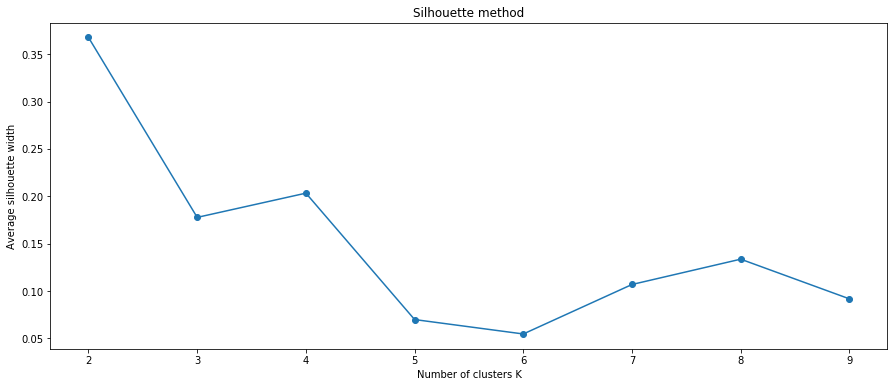

In [142]:
    
plt.figure(figsize=(15, 6))
plt.plot(component_range, silhouette, '-o')
plt.title("Silhouette method")
plt.xlabel(r'Number of clusters K')
plt.ylabel('Average silhouette width')


#### Elbow

Text(0, 0.5, 'sse')

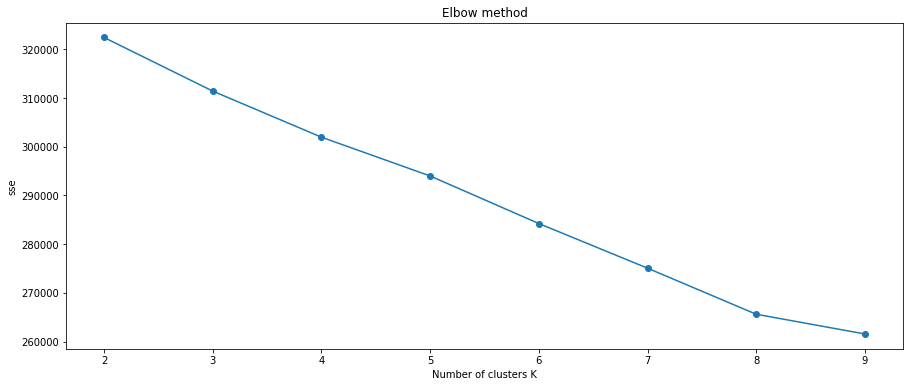

In [143]:
plt.figure(figsize=(15, 6))
plt.plot(component_range, sse, '-o')
plt.title("Elbow method")
plt.xlabel(r'Number of clusters K')
plt.ylabel('sse')

In [94]:
# QUESTION: This graph suggests that 2 is the number of clusters. But the original labels have 3 clases. Should I 
#  go with 3 or 2 classes? And how this decision could affect the score?

#I would try 2,3,4
#You can apply elbow method as well

#### Kmeans

In [161]:
k = 3
t1 = time.time()
kmeans = KMeans(n_clusters=k, random_state=0).fit(principalComponents)
kmeans_labels_pca = kmeans.labels_
print("Time execution:", time.time() - t1)
kmeans_labels_pca.shape

Time execution: 4.426628112792969


(258477,)

In [162]:
k = 3
t1 = time.time()
kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
kmeans_labels = kmeans.labels_
print("Time execution:", time.time() - t1)
kmeans_labels.shape

Time execution: 11.0087411403656


(258477,)

In [163]:
k = 3
t1 = time.time()
kmeans = KMeans(n_clusters=k, random_state=0).fit(most_important)
kmeans_labels_most = kmeans.labels_
print("Time execution:", time.time() - t1)
kmeans_labels_most.shape

Time execution: 1.9517278671264648


(258477,)

#### DBScan

In [16]:
#DBScan with the most important features

db = DBSCAN(eps=10, min_samples=50).fit(features_short)
db_labels = db.labels_
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

KeyboardInterrupt: 

#### OPTICS

In [ ]:
optics_model = OPTICS(min_samples=10,eps=0.05).fit(most_important)
labels_optics = optics_model.labels_

#### Spectral Clustering


In [ ]:
sp = SpectralClustering(n_clusters=3)
sp.fit(features_short)
labels = sp.labels_


In [117]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42).fit(principalComponents)

labels_gmm = gmm.predict(principalComponents)

In [118]:
len(labels_gmm)

258477

In [119]:
#agglomerative_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')  
#labels_agg = agglomerative_model.fit_predict(principalComponents)

### BIRCH

In [120]:
#brc = Birch()
#brc.fit(features)

In [172]:
#labels_birch = brc.predict(features)


(258477,)

### Performance comparison

In [169]:
res = [('Kmeans', kmeans_labels),('kmeans_pca',kmeans_labels_pca), ('kmeans_most',kmeans_labels_most)]

In [170]:
for r in res:
    print(r[0])
    #print("silhouette_score:  %0.3f" %metrics.silhouette_score(features, r[1], metric='euclidean'))
    #print("calinski_harabasz_score:  %0.3f" % metrics.calinski_harabasz_score(features, r[1]))
    #print("davies_bouldin_score:  %0.3f" % metrics.davies_bouldin_score(features, r[1]))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, r[1]))
    print("Completeness: %0.3f" % metrics.completeness_score(labels, r[1]))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels, r[1]))
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels, r[1]))
    print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels, r[1]))
#   print("Silhouette Coefficient: %0.3f"% silhouette_score(train_features, r[1]))
    print("==========================")
    

Kmeans
Homogeneity: 0.083
Completeness: 0.138
V-measure: 0.104
Adjusted Rand Index: 0.085
Adjusted Mutual Information: 0.104
kmeans_pca
Homogeneity: 0.000
Completeness: 0.019
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
kmeans_most
Homogeneity: 0.013
Completeness: 0.013
V-measure: 0.013
Adjusted Rand Index: 0.005
Adjusted Mutual Information: 0.013


In [202]:
res = [('DBscan', db_labels)]

In [203]:
for r in res:
    print(r[0])
    #print("silhouette_score:  %0.3f" %metrics.silhouette_score(features, r[1], metric='euclidean'))
    #print("calinski_harabasz_score:  %0.3f" % metrics.calinski_harabasz_score(features, r[1]))
    #print("davies_bouldin_score:  %0.3f" % metrics.davies_bouldin_score(features, r[1]))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_short, r[1]))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_short, r[1]))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_short, r[1]))
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_short, r[1]))
    print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_short, r[1]))
#   print("Silhouette Coefficient: %0.3f"% silhouette_score(train_features, r[1]))
    print("==========================")

DBscan
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
